In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')
plt.rc('patch', force_edgecolor=True,edgecolor='black')
plt.rc('hist', bins='auto')

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

Using TensorFlow backend.


In [4]:
train = pd.read_csv('wrangled_data/training_post_wrangle_small.csv')

test_full = pd.read_csv('wrangled_data/testing_post_wrangle_small.csv')

test_final = test_full.loc[:,['ID', 'shop_id', 'item_id']]

In [5]:
features = ['date_block_num', 'mean_item', 'mode_item', 'item_name', 'item_category_id', 'item_category_name', 'shop_name']

target = ['item_cnt_month']

values = ['item_cnt_month', 'mean_item', 'mode_item', 'item_name', 'item_category_id', 'item_category_name', 'shop_name']

In [6]:
train.columns

Index(['ID', 'shop_id', 'item_id', 'year', 'month', 'item_cnt_month',
       'date_block_num', 'mean_item', 'mode_item', 'item_name',
       'item_category_id', 'item_category_name', 'shop_name'],
      dtype='object')

In [7]:
train = train.set_index(['ID', 'shop_id', 'item_id', 'year', 'month']).sort_index(axis=0, level=['ID', 'year', 'month'])

In [8]:
train.head()

item_cnt_month  date_block_num  mean_item  \
ID shop_id item_id year month                                              
0  5       5037    2013 1                 0.0             0.0   0.382353   
                        2                 0.0             1.0   0.382353   
                        3                 0.0             2.0   0.382353   
                        4                 0.0             3.0   0.382353   
                        5                 0.0             4.0   0.382353   

                               mode_item  item_name  item_category_id  \
ID shop_id item_id year month                                           
0  5       5037    2013 1            0.0       1195                19   
                        2            0.0       1195                19   
                        3            0.0       1195                19   
                        4            0.0       1195                19   
                        5            0.0       1195                19   

                               item_category_name  shop_name  
ID shop_id item_id year month                                 
0  5       5037    2013 1                      11          3  
                        2                      11          3  
                        3                      11          3  
                        4                      11          3  
                        5                      11          3

In [9]:
y_train = train[train['date_block_num'] == 33]
X_train = train[train['date_block_num'] != 33]

X_test = train[train['date_block_num'] != 0]

In [10]:
y_train = y_train.pivot_table(index = ['ID','shop_id','item_id'], 
                  values = ['item_cnt_month'], columns =['date_block_num']).values

In [11]:
X_train = X_train.pivot_table(index = ['ID','shop_id','item_id'], 
                  values = values, columns =['date_block_num']).values

X_test = X_test.pivot_table(index = ['ID','shop_id','item_id'], 
                  values = values, columns =['date_block_num']).values

In [12]:
dataset_scaled = RobustScaler().fit_transform(X_train)
X_train_scaled = np.expand_dims(dataset_scaled, axis=2)

In [13]:
# dataset_scaled = RobustScaler().fit_transform(X_test)
# dataset_scaled = np.expand_dims(dataset_scaled, axis=2)

In [14]:
X_train_scaled.shape

(214200, 231, 1)

In [15]:
# np.expand_dims(train.values, axis=2).shape

In [16]:
# train.droplevel(['shop_id', 'item_id', 'year', 'month'])

In [17]:
# train.to_numpy()

In [18]:
# train.reset_index().set_index('ID').loc[0].to_numpy()

In [19]:
# print(train.columns[0], train.columns[34], train.columns[68], train.columns[34+68], 
#      train.columns[2*68], train.columns[5*34], train.columns[6*34])

In [20]:
# # X we will keep all columns execpt the last one 
# X_train = np.expand_dims(dataset_scaled[:,:-1],axis = 2)
# # the last column is our label
# y_train = dataset_scaled[:,-1:]

# # for test we keep all the columns execpt the first one
# X_test = np.expand_dims(dataset_scaled[:,1:],axis = 2)

# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 231) (214200, 1) (214200, 231)


In [21]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(128, input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model_lstm.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model_lstm.add(tf.keras.layers.LSTM(128, return_sequences=True))
model_lstm.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model_lstm.add(tf.keras.layers.Dropout(0.3))
model_lstm.add(tf.keras.layers.LSTM(64, return_sequences=False))
model_lstm.add(tf.keras.layers.Dropout(0.3))
model_lstm.add(tf.keras.layers.Dense(1))

model_lstm.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error']) #Starting learning rate
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 231, 128)          66560     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 231, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 231, 128)          131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 231, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 231, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [22]:
history_lstm = model_lstm.fit(X_train_scaled,y_train,batch_size = 4096,epochs = 5)

Train on 214200 samples
Epoch 1/5
214200/214200 [==============================] - 592s 3ms/sample - loss: 30.6096 - mean_squared_error: 30.6096
Epoch 2/5
214200/214200 [==============================] - 591s 3ms/sample - loss: 30.1263 - mean_squared_error: 30.1263
Epoch 3/5
214200/214200 [==============================] - 594s 3ms/sample - loss: 30.6401 - mean_squared_error: 30.6401
Epoch 4/5
214200/214200 [==============================] - 588s 3ms/sample - loss: 30.0003 - mean_squared_error: 30.0003
Epoch 5/5
214200/214200 [==============================] - 586s 3ms/sample - loss: 30.0156 - mean_squared_error: 30.0156


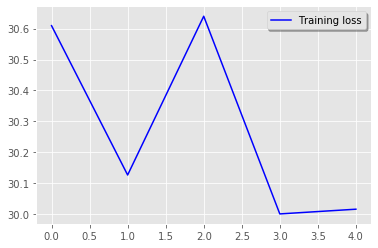

In [23]:
# Plot the loss curves for training
plt.plot(history_lstm.history['loss'], color='b', label="Training loss")
plt.legend(loc='best', shadow=True)

In [27]:
del train

In [28]:
dataset_scaled = RobustScaler().fit_transform(X_test)
X_test = np.expand_dims(dataset_scaled, axis=2)

In [29]:
# creating submission file 
submission_pfs = model_lstm.predict(X_test)
# we will keep every value between 0 and 20
submission_pfs = submission_pfs.clip(0,20)

In [ ]:
# fullset = np.concatenate((dataset_scaled, submission_pfs), 1)

In [ ]:
# fullset[:,1:].shape

In [ ]:
# submission_unscaled = scaler.inverse_transform(fullset[:,1:])

In [ ]:
# submission_unscaled[:,-1].shape

In [31]:
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':test_final['ID'],'item_cnt_month':submission_pfs[:,-1].ravel()})
# creating csv file from dataframe
submission.to_csv('submission_files/robustscale_feature_eng.csv',index = False)

In [32]:
submission.head(3)

,ID,item_cnt_month
0,0,0.495383
1,1,0.043654
2,2,0.424268


In [34]:
submission.shape, test_final.shape

((214200, 2), (214200, 3))